In [1]:
import os
from csv import reader
import numpy as np
import copy
from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import SGD,Adam
from keras.regularizers import l1, l2

from numpy.lib.recfunctions import stack_arrays
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

import pickle

from pandas import read_csv,DataFrame

Using TensorFlow backend.
/user/smoortga/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Reading the data

In [89]:
data = read_csv("./disease_train.csv",";")
feature_names = [i for i in data.columns if not i == "id" and not i == "disease"]
#feature_names

input_data = data[feature_names]

# add BMI
input_data.loc[:,"bmi"] = input_data.loc[:,'weight']/(0.01*input_data.loc[:,'height'])**2 #kg/m2
feature_names.append("bmi")

# add high BP (binary)
input_data.loc[:,"high_bp"] = ((input_data.loc[:,'ap_hi']>=140).astype(int)) * ((input_data.loc[:,'ap_lo']>=90).astype(int)) #ap_hi > 140 and ap_lo > 90
feature_names.append("high_bp")

# transfer age in years (approximate, forget about leap years etc)
input_data.loc[:,"age"] = input_data.loc[:,"age"]/365.

target_data = data.loc[:,"disease"]
target_data_categorical = np_utils.to_categorical(target_data.astype(int), 2)# 2classes

#input_data

# Task 1  

## Explarotory data analysis

Before feeding data into any ML model, it's important tot understand your data. It is especially relevant to look at distributions of input features and compare them between different output classes (disease or not in this case). This allows to detect features that might not have a lot of discriminating power. Also one needs to check whether all input data are filled with meaningful values. Outliers (due to failed measurements for example) could bias the results of the ML model. Finally, correlations between input features can give useful information on how to combine them (derive new features from existing ones?) or even on which variables to drop (because they do not contain independent information that can be used)

## Draw (normalized) distributions

age
gender
height
weight
ap_hi
ap_lo
cholesterol
gluc
smoke
alco
active
bmi
high_bp


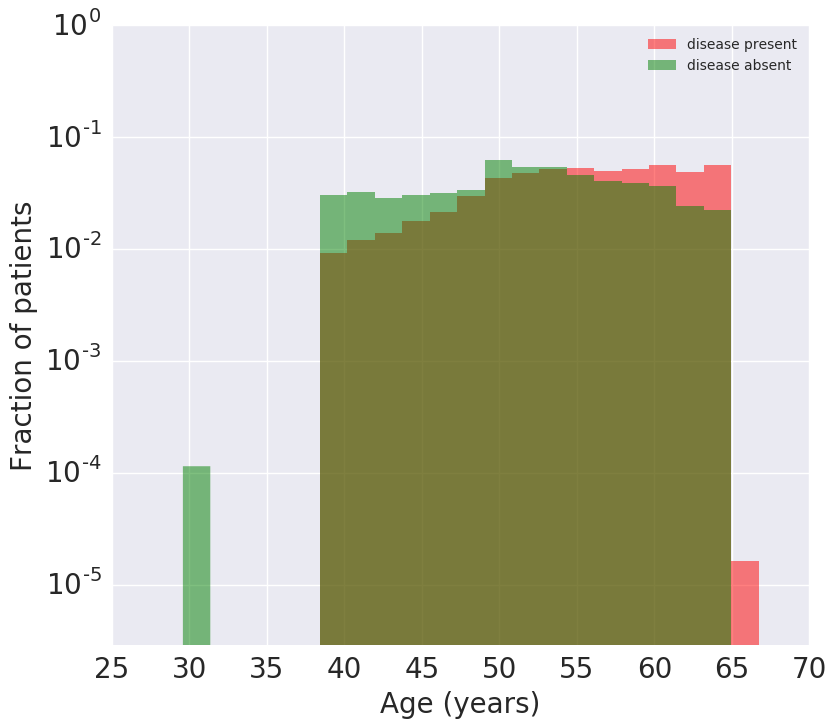

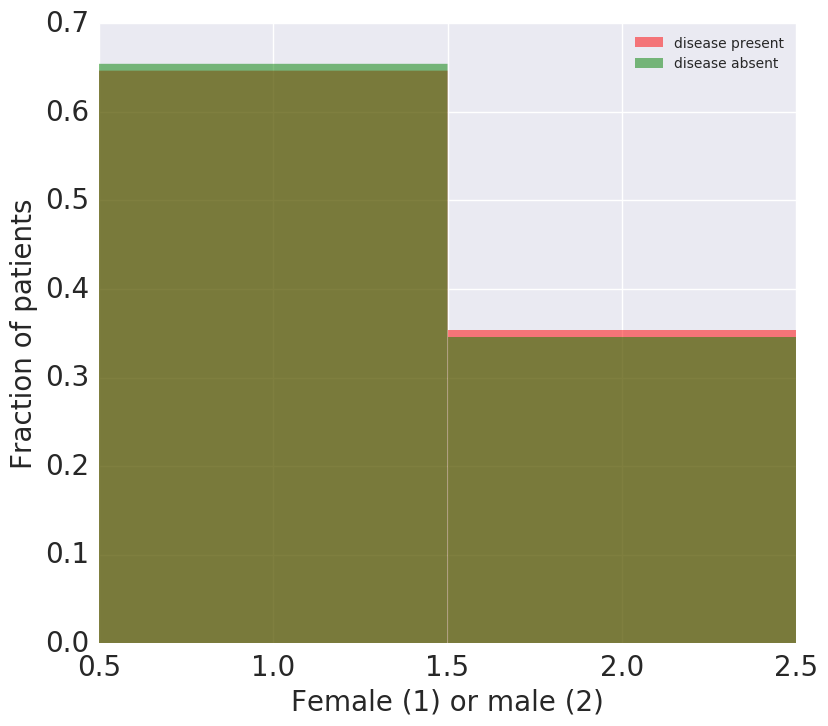

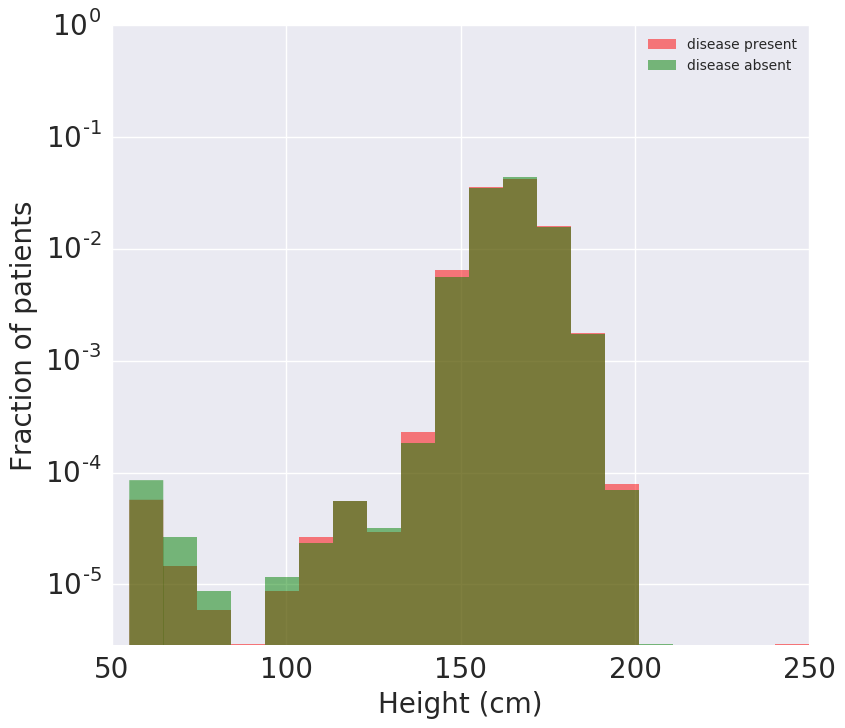

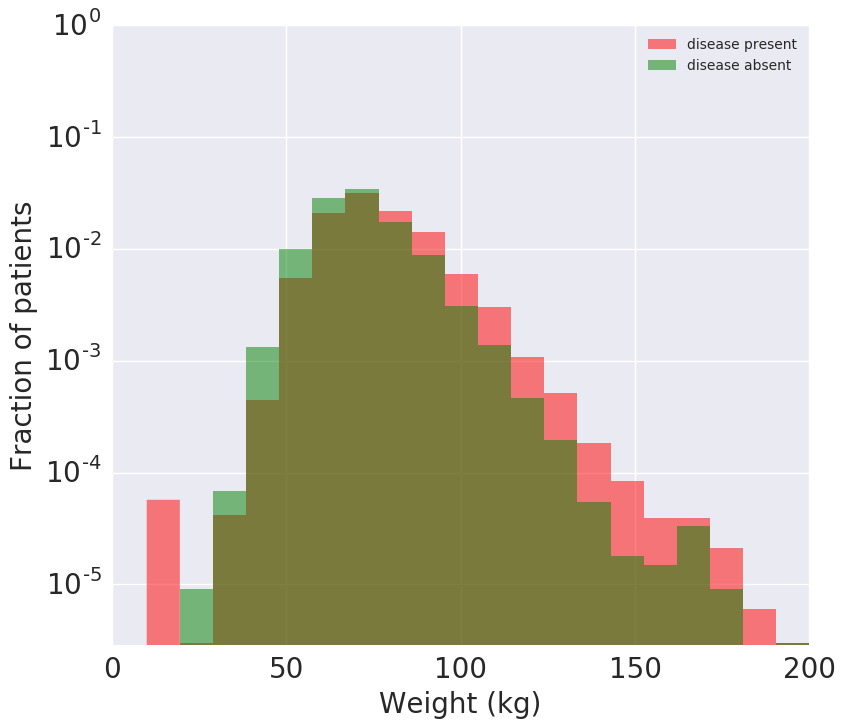

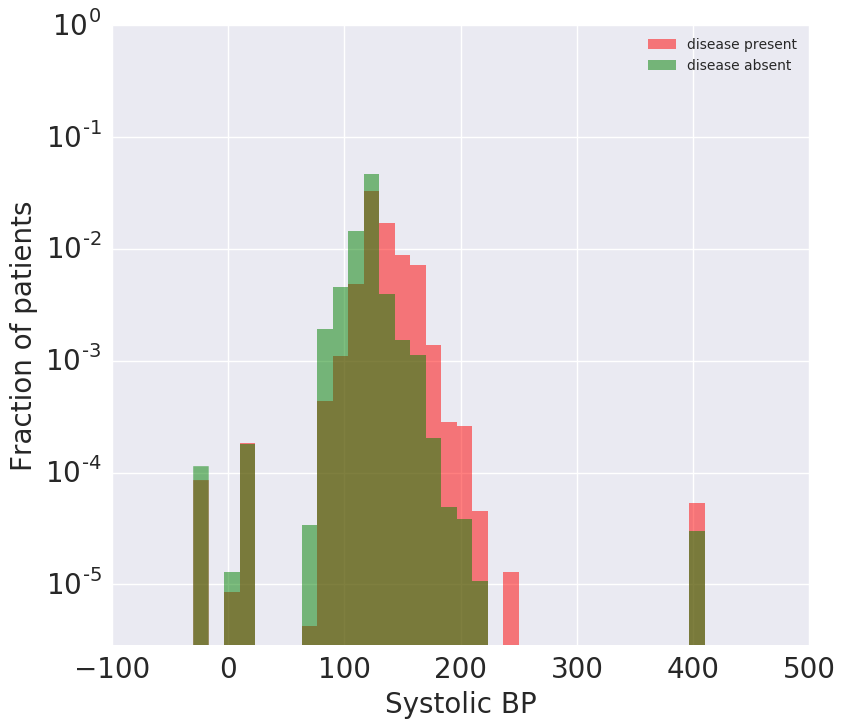

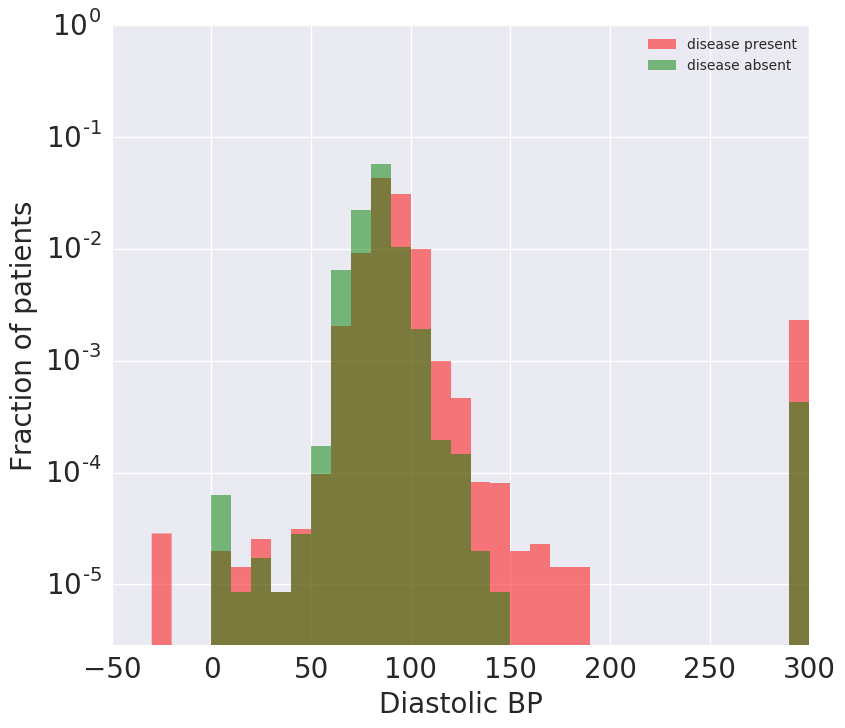

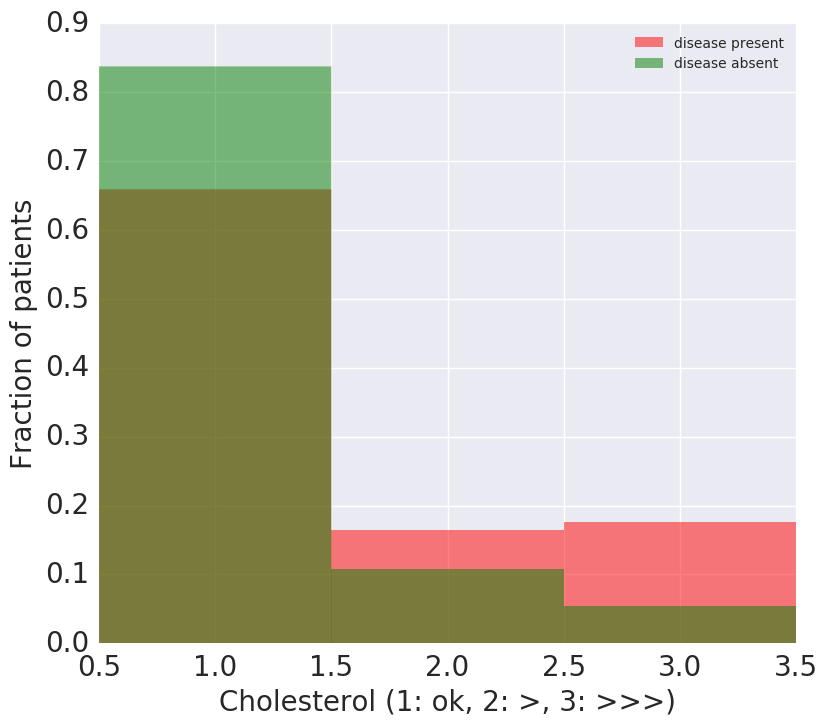

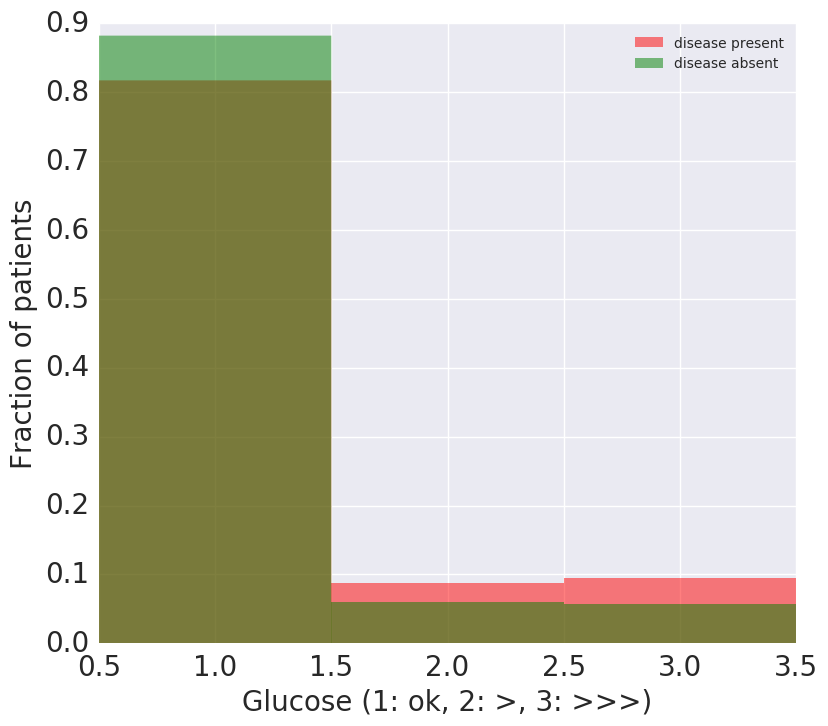

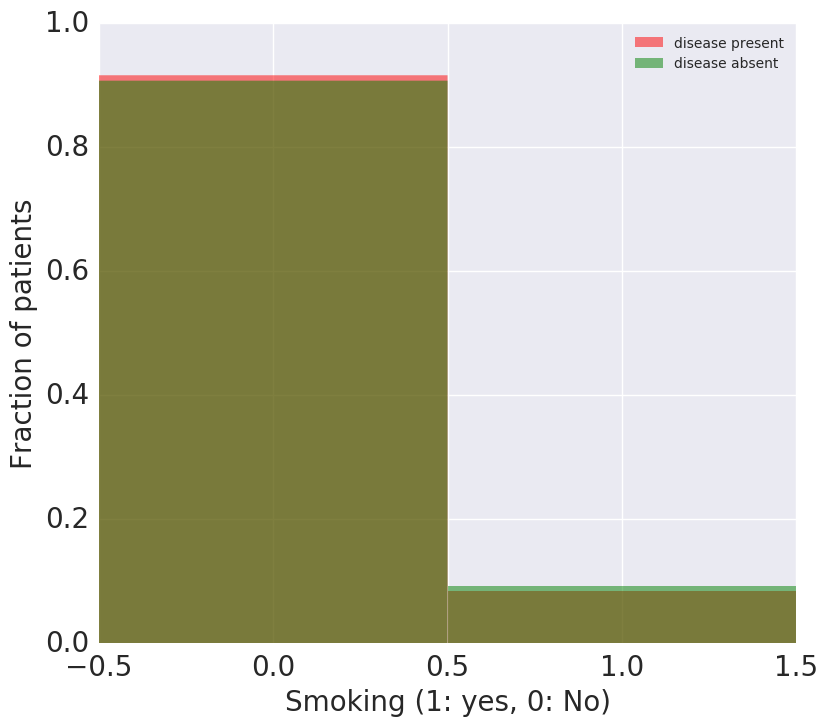

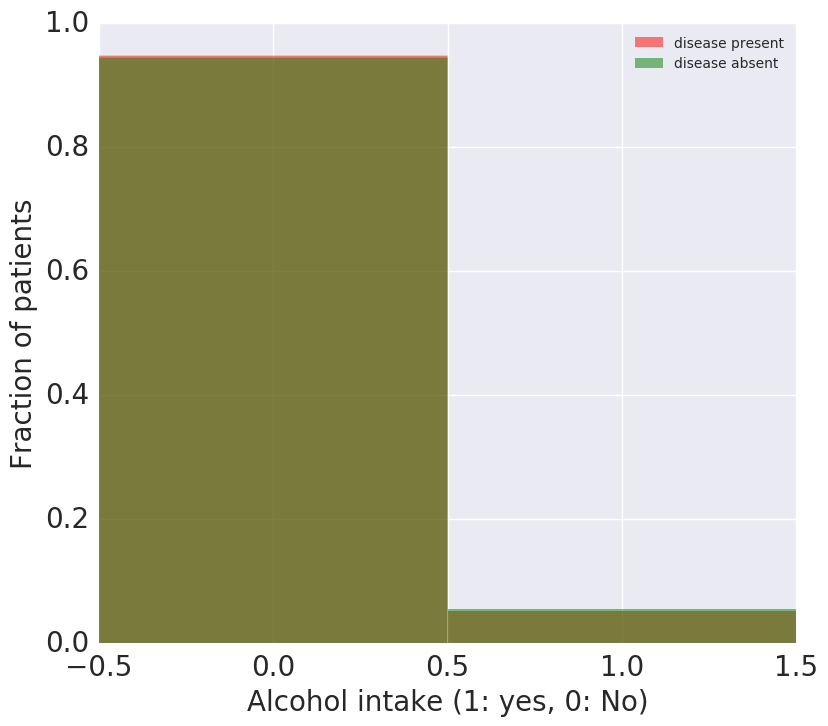

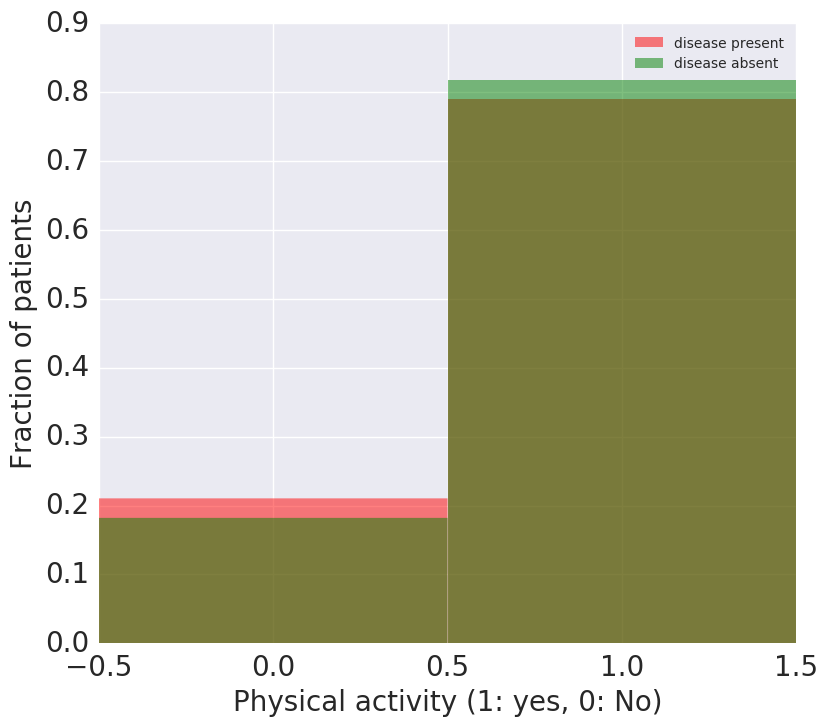

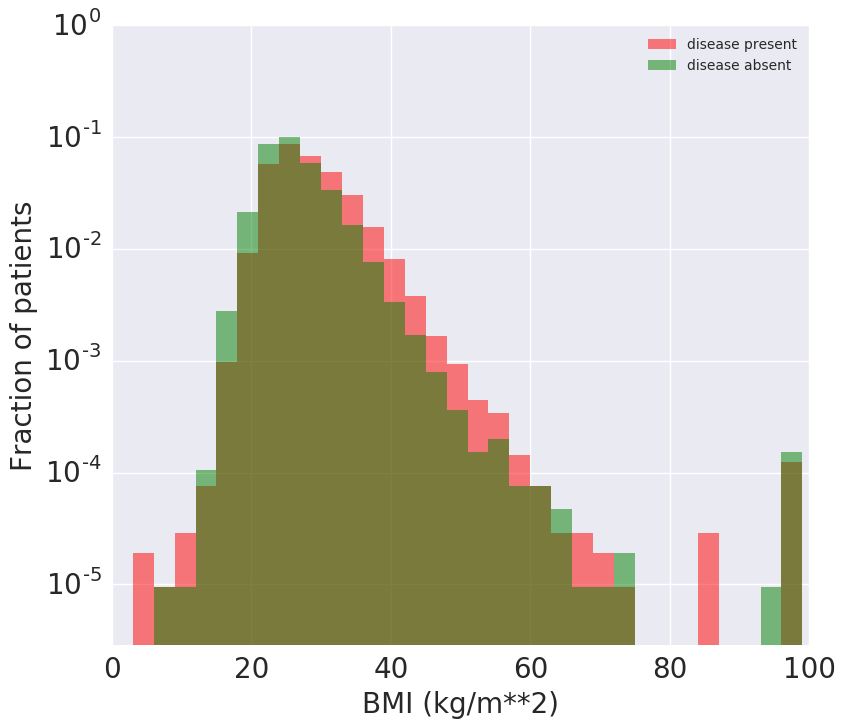

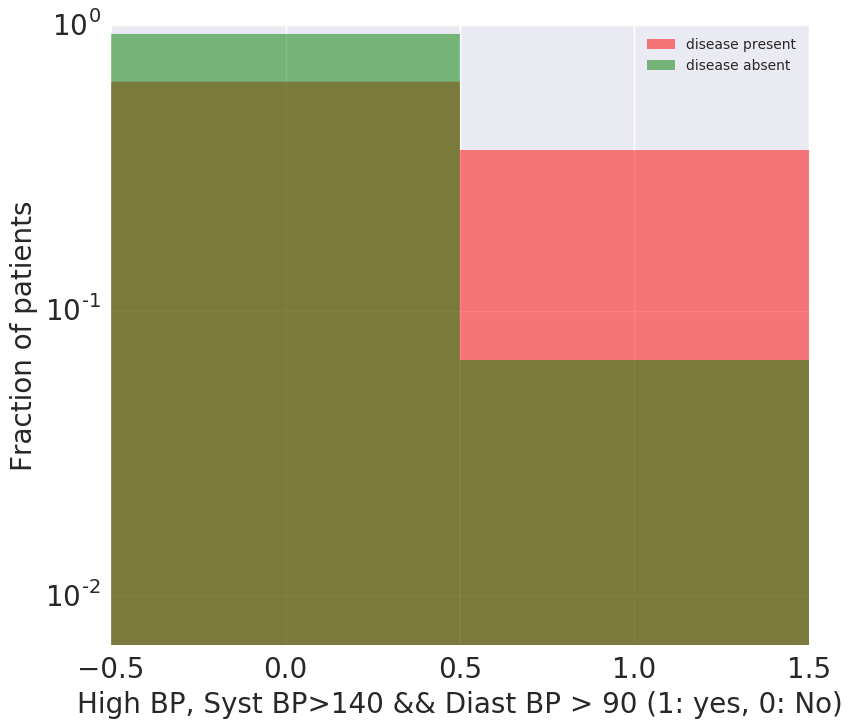

In [3]:
def draw_feat_histogram(name,dataframe,truth,bins,x_axis_label,set_log = 0):
    fig = plt.figure(figsize=[9,8]) 
    ax = fig.add_subplot(1,1,1)
    x_1, bins_1, p_1 = ax.hist(np.clip(dataframe[truth==1], bins[0], bins[-1]),bins,label="disease present",alpha=0.5,color='red',linewidth=0,normed = 1)
    for item in p_1:
        item.set_height(item.get_height()/sum(x_1))
        x_1 = x_1/sum(x_1)
    x_0, bins_0, p_0 = ax.hist(np.clip(dataframe[truth==0], bins[0], bins[-1]),bins,label="disease absent",alpha=0.5,color='green',linewidth=0,normed = 1)
    for item in p_0:
        item.set_height(item.get_height()/sum(x_0))
        x_0 = x_0/sum(x_0)
        
    plt.xlabel(name,fontsize=25)
    plt.ylabel("Fraction of patients",fontsize=20)
    plt.xlabel(x_axis_label,fontsize=20);
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    if set_log: 
        plt.yscale("log")
        lower_boundary = min(np.concatenate((x_1[x_1 != 0],x_0[x_0!= 0])))
        plt.ylim(lower_boundary/10.,1.)
    plt.legend(loc='best')
    return fig


display_dict = {
       "age":{
            "axislabel":"Age (years)",
            "min":min(input_data["age"]),
            "max":max(input_data["age"]),
            "step":abs(max(input_data["age"])-min(input_data["age"]))/20.,
            "logy":True
        },
        "gender":{
            "axislabel":"Female (1) or male (2)",
            "min":0.5,
            "max":2.5,
            "step":1,
            "logy":False
        },
         "height":{
            "axislabel":"Height (cm)",
            "min":min(input_data["height"]),
            "max":max(input_data["height"]),
            "step":abs(max(input_data["height"])-min(input_data["height"]))/20.,
            "logy":True
        },
         "weight":{
            "axislabel":"Weight (kg)",
            "min":min(input_data["weight"]),
            "max":max(input_data["weight"]),
            "step":abs(max(input_data["weight"])-min(input_data["weight"]))/20.,
            "logy":True
        },
        "ap_hi":{
            "axislabel":"Systolic BP",
            "min":-30,
            "max":400,
            "step":400/30.,
            "logy":True
        },
        "ap_lo":{
            "axislabel":"Diastolic BP",
            "min":-30,
            "max":300,
            "step":300/30.,
            "logy":True
        },
        "cholesterol":{
            "axislabel":"Cholesterol (1: ok, 2: >, 3: >>>)",
            "min":0.5,
            "max":3.5,
            "step":1,
            "logy":False
        },
        "gluc":{
            "axislabel":"Glucose (1: ok, 2: >, 3: >>>)",
            "min":0.5,
            "max":3.5,
            "step":1,
            "logy":False
        },
        "smoke":{
            "axislabel":"Smoking (1: yes, 0: No)",
            "min":-0.5,
            "max":1.5,
            "step":1,
            "logy":False
        },
        "alco":{
            "axislabel":"Alcohol intake (1: yes, 0: No)",
            "min":-0.5,
            "max":1.5,
            "step":1,
            "logy":False
        },
        "active":{
            "axislabel":"Physical activity (1: yes, 0: No)",
            "min":-0.5,
            "max":1.5,
            "step":1,
            "logy":False
        },
        "bmi":{
            "axislabel":"BMI (kg/m**2)",
            "min":0,
            "max":99,
            "step":3,
            "logy":True
        },
        "high_bp":{
            "axislabel":"High BP, Syst BP>140 && Diast BP > 90 (1: yes, 0: No)",
            "min":-0.5,
            "max":1.5,
            "step":1,
            "logy":True
        },

}


for feat in feature_names:
    print feat
    assert feat in display_dict.keys(), "%s not found in display_dict!"%feat
    bins = np.arange(display_dict[feat]["min"],display_dict[feat]["max"]+display_dict[feat]["step"],display_dict[feat]["step"])
    fig_ = draw_feat_histogram(feat,input_data[feat],target_data,bins,x_axis_label=display_dict[feat]["axislabel"],set_log=display_dict[feat]["logy"])
    plt.draw()
    

## Check variable (linear) correlations

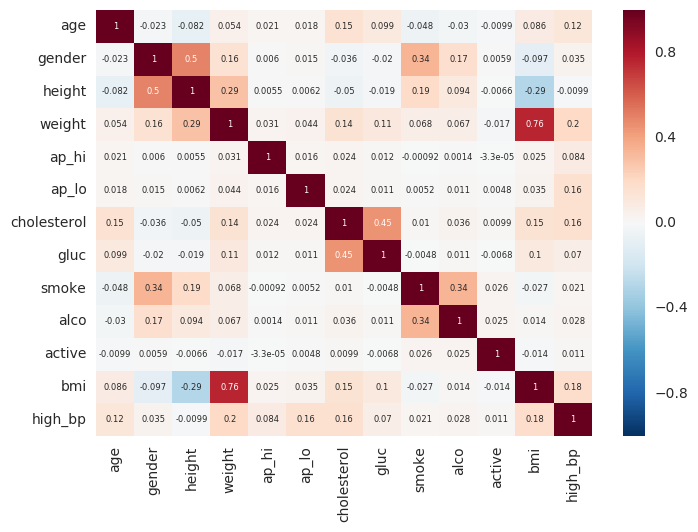

In [4]:
correlation_mat = input_data.corr()
sns.heatmap(correlation_mat, annot = True, annot_kws={"size": 6})
plt.show()

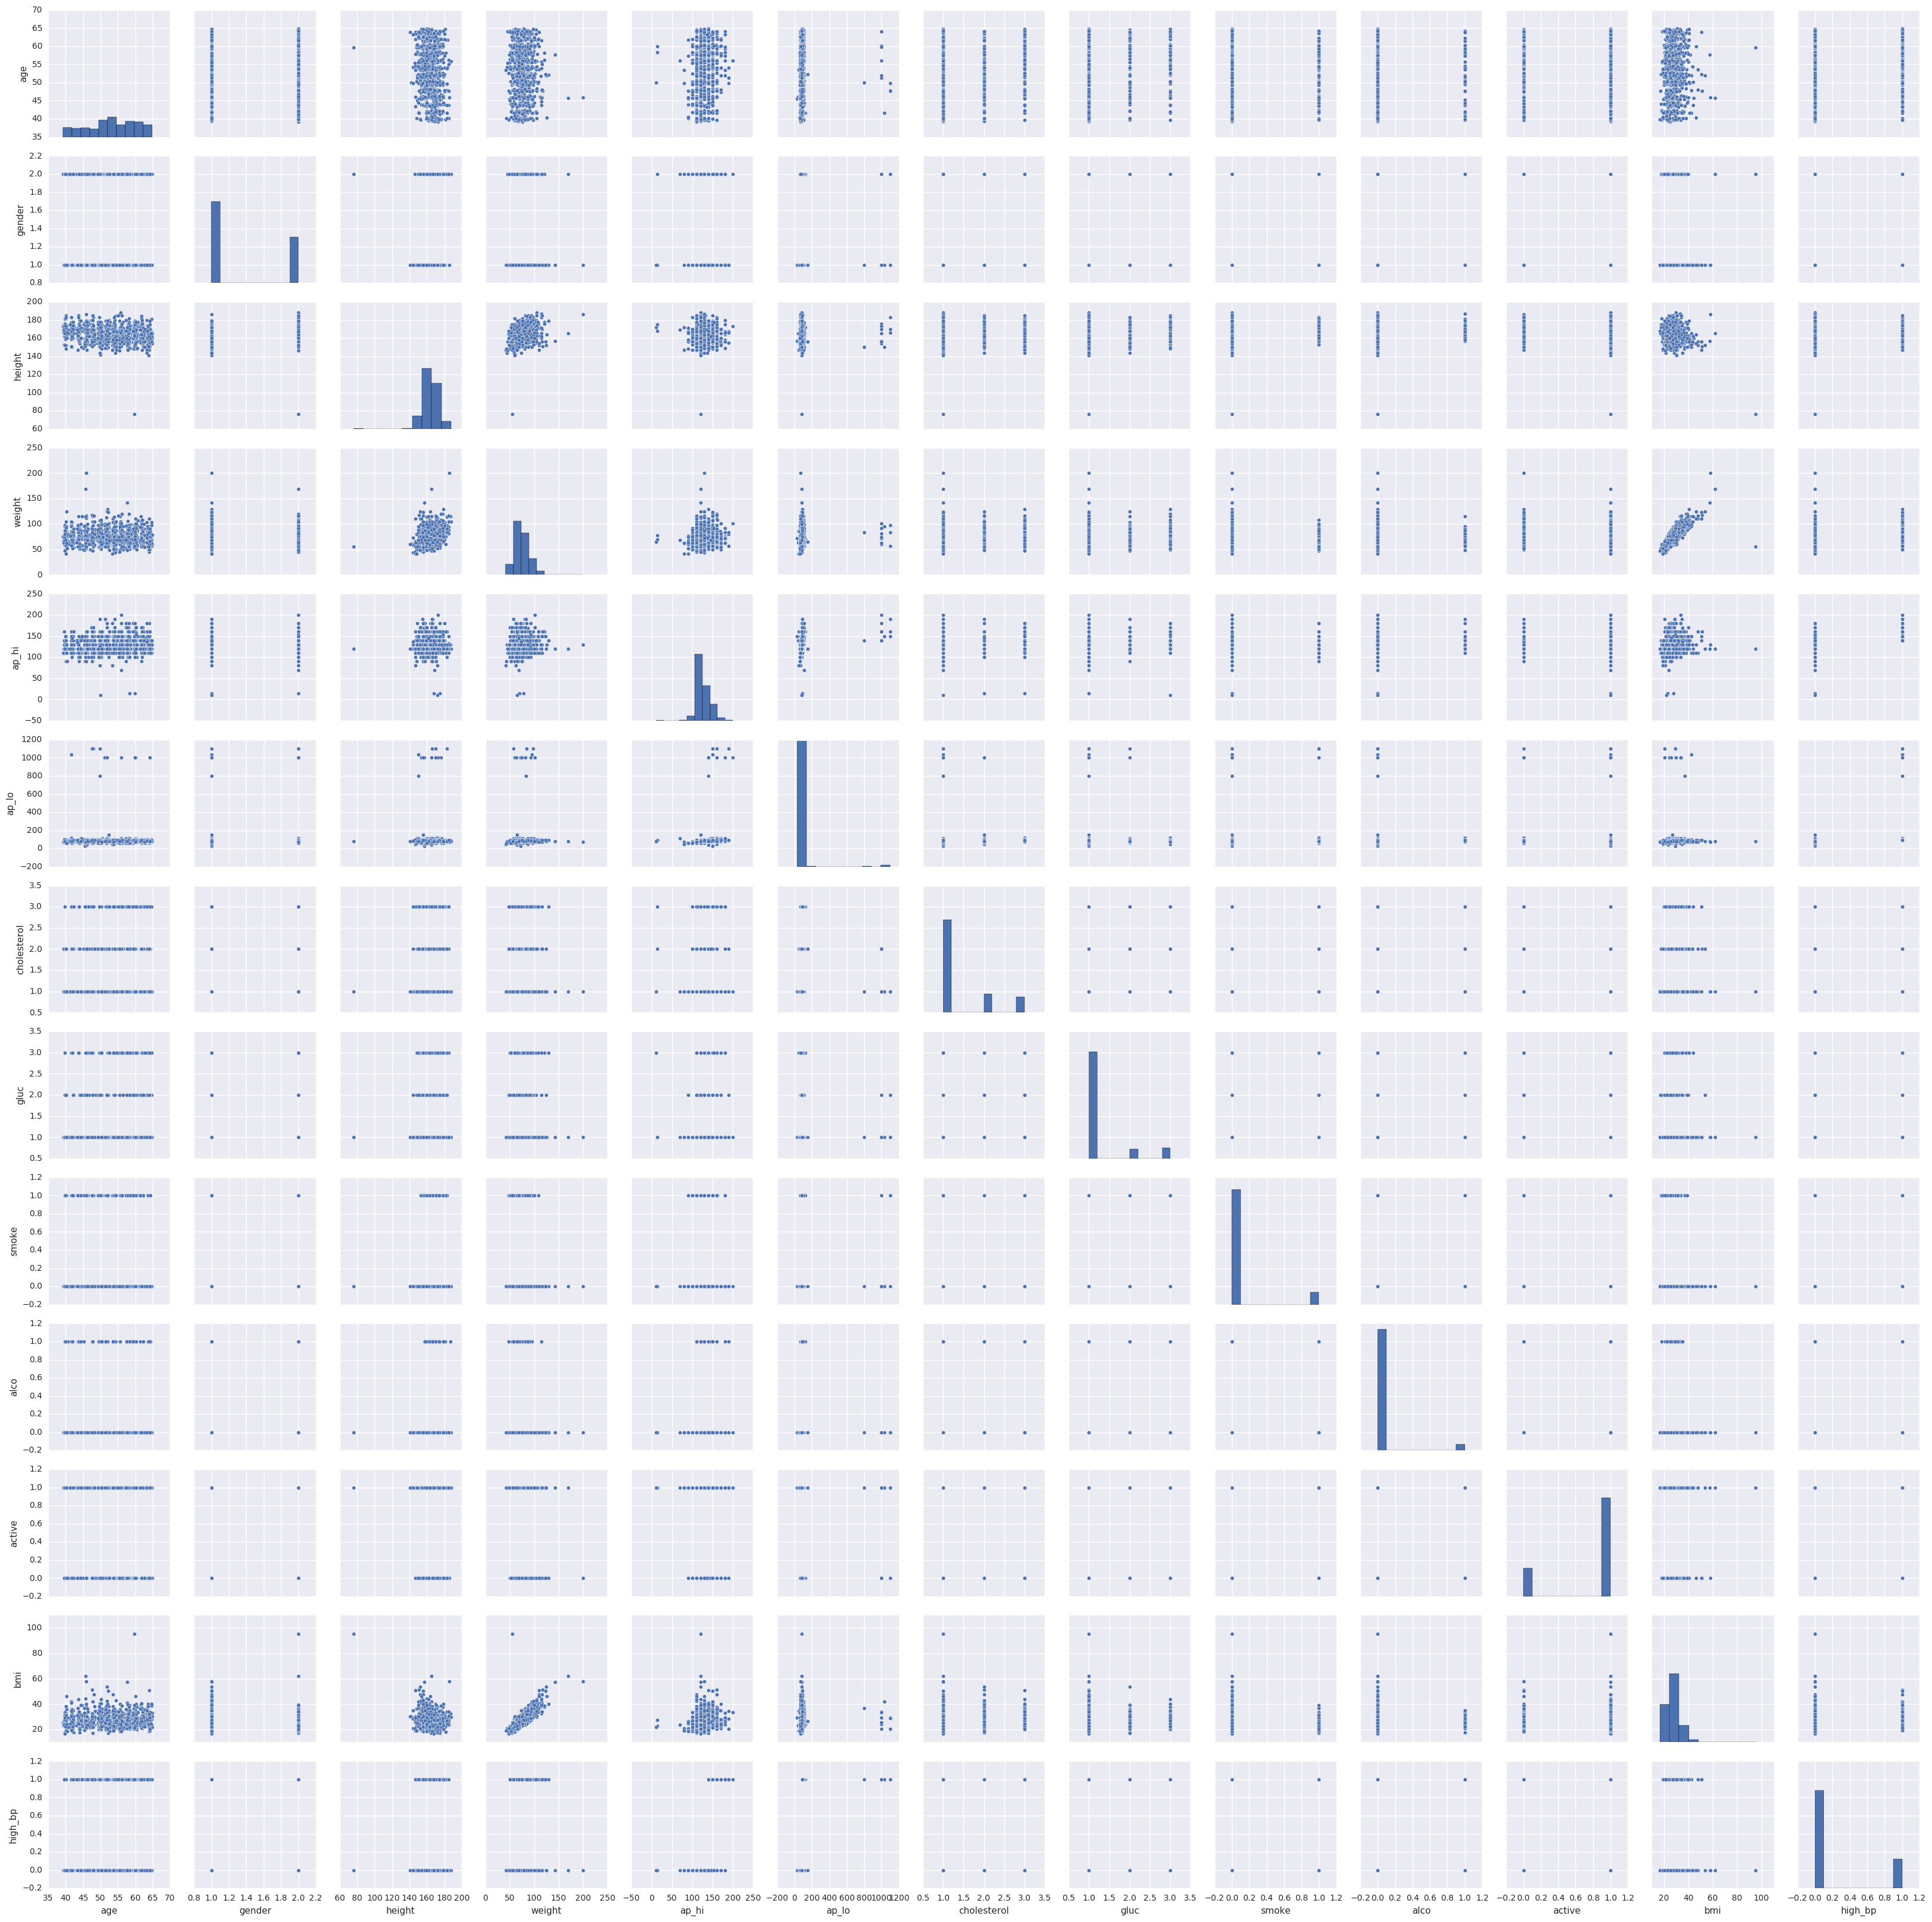

In [8]:
sns.pairplot(input_data[:1000])

## Some final checks

In [9]:
print "# people with disease in the test group: %i"%(sum(target_data == 1))
print "# people without disease in the test group: %i"%(sum(target_data == 0))
print""

print input_data["age"][input_data["height"]<100]

print input_data["age"][input_data["age"]<35]

# people with disease in the test group: 34979
# people without disease in the test group: 35021

224      59.726027
7598     40.167123
8171     48.345205
12770    53.682192
13265    61.523288
14323    60.287671
15167    43.320548
16699    53.917808
17277    48.027397
22542    39.830137
22723    64.071233
23913    52.257534
27384    41.895890
27603    57.473973
28737    54.101370
29157    52.295890
32098    42.120548
33607    53.997260
44490    52.383562
46319    57.550685
47352    63.827397
50789    39.723288
51459    42.279452
53344    56.276712
56022    58.002740
64115    50.482192
64454    58.487671
65302    50.594521
66643    51.589041
Name: age, dtype: float64
6219     29.802740
22343    29.583562
30666    29.750685
55905    30.038356
Name: age, dtype: float64


## Discussion

Age: Mostly affects older people, test group mostly between 40-65 years of age, with a small group ~ 30 years of age

Gender: ~ 2/3 female, 1/3 male. Seems to affect each gender equally... (slightly more in male category. Could be significant but will not be a large leverage for the ML algorithm)

Height: No clear indication for desease. Some (very few) people who are < 1 meter (their age is > 40). 

Weight + BMI: clearly affect higher BMI (overweight?). Large correlation ($\rho = 0.76$) between Weight and BMI (of course). Since Height is not a good variable for identifying the disease, Weight and BMI will contain almost the same information for any ML algorithm.

Systolic and Diastolic BP and "high BP " boolian: Higher BP is indication for disease. Yet there is a relatively small correlation between Syst and Dia, and because of that also "high BP" is very useful, which asks for a high Syst AND Dia BP. Could be worth to also include the "Sum of Dia and Syst"?
--> NOTE: some measurements have extremely high >500 or negative readings. So they have probably failed. Might be worth to put these to defaulted values (-1), but then again they are a vast minority so they will have a very small impact in the loss function.

Colesterol and Glucose: both indicate that high values are an indication of the disease. But there is also a large corrrelation between the two ($\rho = 0.45$), so might not be completely independent information.

Smoking + Alcohol: Relatively large correlation (but correlation does not mean causation of course). But does not seem to be a clear indication of the disease.

Physically active: Lack of physical activity could increase chance of having the disease.


# Task 2

## Split dataset for training and testing

In [77]:
testing_size = 0.3 # 30% for testing


input_data_train, input_data_test , target_data_train, target_data_test, target_data_categorical_train, target_data_categorical_test = train_test_split(input_data, target_data, target_data_categorical, test_size=testing_size)

## Train a feed-forward NN using Keras

In [36]:
init_learning_rate_sgd = 0.001
nb_epoch = 100
batch_size = 128
input_dim = input_data.shape[1:]
dropout=0.2
nb_classes=2

decay_sgd = init_learning_rate_sgd/(float(nb_epoch) )
sgd = SGD(lr=init_learning_rate_sgd, decay=decay_sgd, momentum=0.7, nesterov=True)


model = Sequential([
    Dense(50, activation='relu',input_shape = input_dim),
    Dropout(dropout),
    Dense(20, activation='relu'),
    Dropout(dropout),
    Dense(2, activation='softmax')
  ])

model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

#model = load_model("model_checkpoint_NN_save_bestsofar.hdf5")


print model.summary()

#train_history = model.fit(input_data_train.values, target_data_categorical_train, batch_size=batch_size, nb_epoch=nb_epoch, validation_data=(input_data_test.values, target_data_categorical_test), callbacks = [ModelCheckpoint(os.getcwd() + "/model_checkpoint_NN_save.hdf5")], shuffle=True,verbose=1)
#pickle.dump(train_history.history,open(os.getcwd() + "/loss_and_acc_NN.pkl",'wb'))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_10 (Dense)                 (None, 50)            700         dense_input_5[0][0]              
____________________________________________________________________________________________________
dropout_7 (Dropout)              (None, 50)            0           dense_10[0][0]                   
____________________________________________________________________________________________________
dense_11 (Dense)                 (None, 20)            1020        dropout_7[0][0]                  
____________________________________________________________________________________________________
dropout_8 (Dropout)              (None, 20)            0           dense_11[0][0]                   
___________________________________________________________________________________________

## Inspect training curve (good convergence + no overtraining)

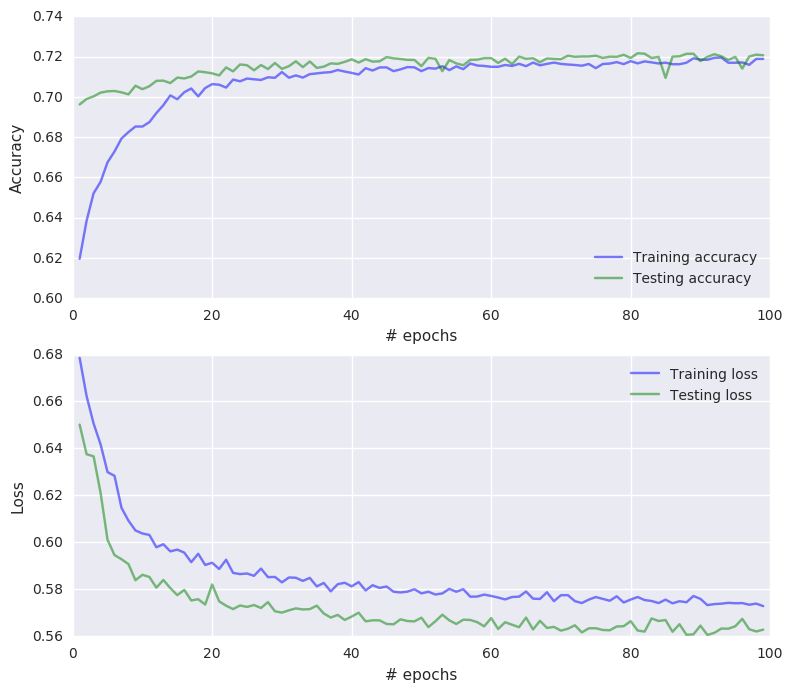

In [11]:
model = load_model("model_checkpoint_NN_save_bestsofar.hdf5")
train_history = pickle.load(open(os.getcwd() + "/loss_and_acc_NN.pkl",'rb'))


tr_acc = train_history["acc"][1:]
tr_loss = train_history["loss"][1:]
val_acc = train_history["val_acc"][1:]
val_loss = train_history["val_loss"][1:]
epochs = range(1,len(tr_acc)+1)
               
fig = plt.figure(figsize=[9,8]) 
ax_acc = fig.add_subplot(2,1,1)               
ax_acc.plot(epochs, tr_acc, 'b', alpha=0.5, label = 'Training accuracy')
ax_acc.plot(epochs, val_acc, 'g', alpha=0.5, label = 'Testing accuracy')
plt.legend(loc = 'lower right')
plt.ylabel('Accuracy')
plt.xlabel('# epochs')

ax_loss = fig.add_subplot(2,1,2)               
ax_loss.plot(epochs, tr_loss, 'b', alpha=0.5, label = 'Training loss')
ax_loss.plot(epochs, val_loss, 'g', alpha=0.5, label = 'Testing loss')
plt.legend(loc = 'upper right')
plt.ylabel('Loss')
plt.xlabel('# epochs')


plt.show()

## Look at the output discriminator

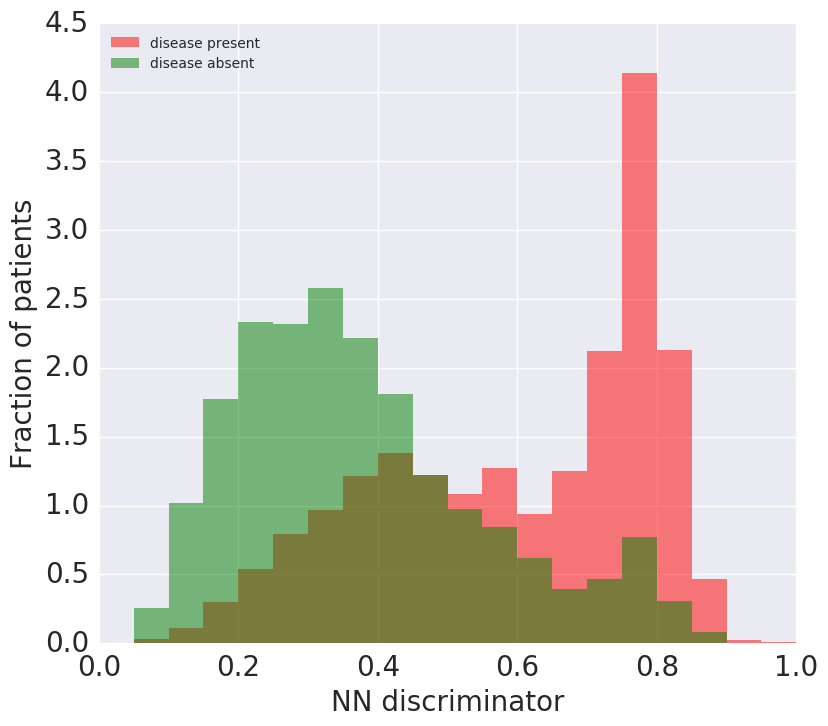

In [12]:
output_test = DataFrame(data=model.predict(input_data_test.values)[:,1],columns=["discriminator_NN"])
output_target = DataFrame(data=np.asarray(target_data_test),columns=["disease"])
bins=np.arange(0.,1.05,0.05)
fig_ = draw_feat_histogram("discriminator_NN",output_test["discriminator_NN"],output_target["disease"],bins,x_axis_label="NN discriminator",set_log=False)
plt.draw()

## Look at ROC (and AUC)

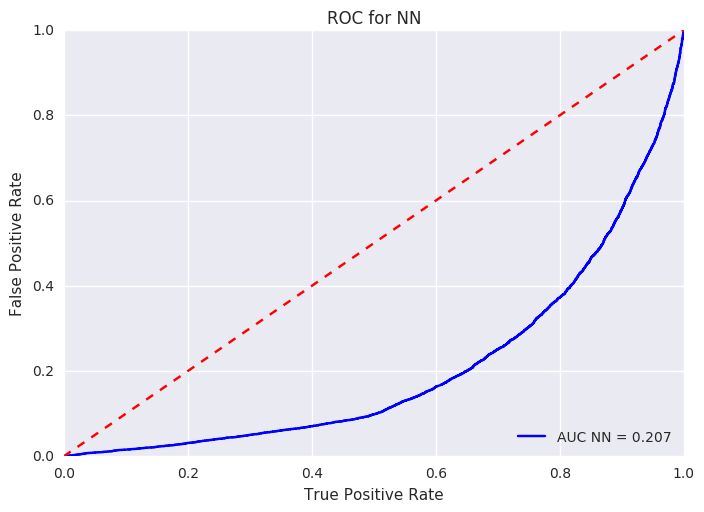

In [13]:
fpr_NN, tpr_NN, thres_NN = roc_curve( output_target,output_test )
AUC_NN = 1-roc_auc_score( output_target,output_test  )

plt.title('ROC for NN')
plt.plot(tpr_NN,fpr_NN, 'b', label = 'AUC NN = %0.3f' % AUC_NN)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')

plt.show()

## what metric to use?
The Area Under the ROC (AUC) gives an idea about the overall performance. 

But for specific cases, one might want to adopt other metrics. For example, when making a diagnosis for a disease, one would not want to tell a healthy patient he is ill, starting an expensive treatment that was not necessary. This means the false positive rate should be kept very low. One could then for example focus on the identification efficiency (true positive rate) at a fixed (low) false positive rate. This is often called a high-purity metric. 

In particle physics we sometimes want to identify our signal process with a very high efficiency, especially when a certain process has only very little backgorund in the first place. There we want a high-efficiency (large tpr) metric, where we can handle a reltively large fpr.

Another possibility is to determine the Optimal Operating Point, which is the point on the ROC closest to "(fpr,trp) = (0,1)"

## BDT using Scikit Learn

In [14]:
bdt_settings_dict = {
#     1: {'n_estimators': 500, 
#         'max_leaf_nodes': 4, 
#         'max_depth': 4, 
#         'random_state': 2,
#         'min_samples_split': 50 ,
#         'loss': 'deviance',
#         'verbose': 1 
#     },
    2: {'n_estimators': 500, # number of (shallow) trees in the ensemble  #
        'max_depth': 4, # max depth of each shallow tree
        'random_state': 2,
        'min_samples_split': 50 , # min number of patients to further split a node
        'loss': 'exponential',
        'verbose': 1 
    },
    
}
for set_idx, settings in bdt_settings_dict.iteritems():
    print set_idx
    bdt = GradientBoostingClassifier(**settings)
    bdt.fit(input_data_train.values, target_data_train)
    output_test_bdt = DataFrame(data=bdt.predict_proba(input_data_test.values)[:,1],columns=["discriminator_bdt"])
    fpr_bdt, tpr_bdt, thres_bdt = roc_curve( output_target,output_test_bdt )
    AUC_bdt = 1-roc_auc_score( output_target,output_test_bdt  )
    
print AUC_bdt

2
      Iter       Train Loss   Remaining Time 
         1           0.9749           45.80s
         2           0.9537           40.97s
         3           0.9358           38.99s
         4           0.9207           40.36s
         5           0.9080           43.87s
         6           0.8975           43.50s
         7           0.8885           42.27s
         8           0.8810           41.28s
         9           0.8747           40.56s
        10           0.8693           39.92s
        20           0.8443           38.62s
        30           0.8365           35.09s
        40           0.8327           31.77s
        50           0.8302           29.97s
        60           0.8285           27.75s
        70           0.8272           25.84s
        80           0.8260           24.23s
        90           0.8251           22.59s
       100           0.8241           21.92s
       200           0.8160           14.07s
       300           0.8096            8.68s
       

## k-NN using Scikit Learn

In [11]:
knn_settings_dict = {
    1: {'n_neighbors': 200, # 200 neighbours to consider in the metric
        'weights': 'distance', #distance/uniform
    },
    
}
for set_idx, settings in knn_settings_dict.iteritems():
    print set_idx
    knn = KNeighborsClassifier(**settings)
    knn.fit(input_data_train.values, target_data_train)
    output_test_knn = DataFrame(data=knn.predict_proba(input_data_test.values)[:,1],columns=["discriminator_knn"])
    fpr_knn, tpr_knn, thres_knn = roc_curve( output_target,output_test_knn )
    AUC_knn = 1-roc_auc_score( output_target,output_test_knn  )
    
print AUC_knn

1
0.217644345303


## Single Decision Tree using Scikit Learn

In [14]:
dt_settings_dict = {
    1: {'max_depth': 800, 
        'min_samples_split': 1000, 
        'max_features':"auto",
    },
    
}
for set_idx, settings in dt_settings_dict.iteritems():
    print set_idx
    dt = DecisionTreeClassifier(**settings)
    dt.fit(input_data_train.values, target_data_train)
    output_test_dt = DataFrame(data=dt.predict_proba(input_data_test.values)[:,1],columns=["discriminator_dt"])
    fpr_dt, tpr_dt, thres_dt = roc_curve( output_target,output_test_dt )
    AUC_dt = 1-roc_auc_score( output_target,output_test_dt  )
    
print AUC_dt

1
0.22028652629


## Draw comparison of the ROCs

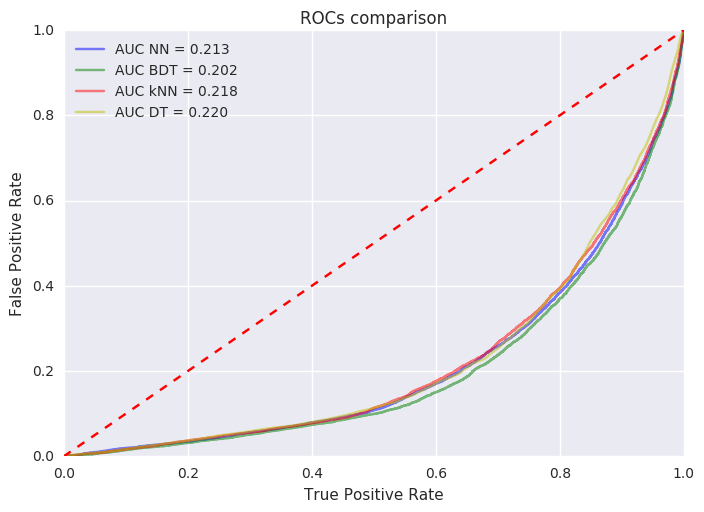

In [15]:

plt.title('ROCs comparison')
plt.plot(tpr_NN,fpr_NN, 'b', alpha=0.5, label = 'AUC NN = %0.3f' % AUC_NN)
plt.plot(tpr_bdt,fpr_bdt, 'g', alpha=0.5, label = 'AUC BDT = %0.3f' % AUC_bdt)
plt.plot(tpr_knn,fpr_knn, 'r', alpha=0.5, label = 'AUC kNN = %0.3f' % AUC_knn)
plt.plot(tpr_dt,fpr_dt, 'y', alpha=0.5, label = 'AUC DT = %0.3f' % AUC_dt)
plt.legend(loc = 'upper left')
plt.plot([0, 1], [0, 1],'r--')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')

plt.show()

The BDT seems to perform the best, followed by the NN, the kNN and the DT. Nevertheless, all models are pretty close in performance. A proper opitmization of each model could result in a more clear difference in performance.

# Task 3:

## Feature importance for the BDT (Gini importance, i.e. Mean decrease in Impurity)

In [106]:
"""
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.feature_importances_

The impurity-based feature importances.

The higher, the more important the feature. 
The importance of a feature is computed as the (normalized) total 
reduction of the criterion brought by that feature. It is also known as the Gini importance.


Gini Importance / Mean Decrease in Impurity (MDI)

MDI counts the times a feature is used to split a node, weighted by the number of samples it splits:

    Gini Importance or Mean Decrease in Impurity (MDI) calculates each feature importance as the sum over the number of splits (across all tress) that include the feature, proportionally to the number of samples it splits.

However, Gilles Louppe gave a different version in [4]. Instead of counting splits, the actual decrease in node impurity is summed and averaged across all trees. (weighted by the number of samples it splits).

"""

bdt_importance = (zip(feature_names,bdt.feature_importances_ ))
bdt_importance.sort(key = lambda x: x[1],reverse=True) 
for idx,(name,imp) in enumerate(bdt_importance):
    print idx, name, imp

# take only those features that are above 0.01 in importance
features_important_bdt = [name for name,imp in bdt_importance if imp > 0.01]
print features_important_bdt


0 age 0.31843120131
1 bmi 0.217981207162
2 ap_hi 0.135079214116
3 height 0.0873831771859
4 weight 0.0840948781198
5 ap_lo 0.0749610482172
6 gluc 0.0223815178504
7 cholesterol 0.0194148455604
8 active 0.01177424731
9 gender 0.00978404319694
10 smoke 0.00895152931206
11 alco 0.00743000582166
12 high_bp 0.00233308483789
['age', 'bmi', 'ap_hi', 'height', 'weight', 'ap_lo', 'gluc', 'cholesterol', 'active']


In [17]:
input_data_bdt_high_import = input_data[features_important_bdt]
input_data_bdt_high_import_train, input_data_bdt_high_import_test , target_data_bdt_high_import_train, target_data_bdt_high_import_test, target_data_bdt_high_import_categorical_train, target_data_bdt_high_import_categorical_test = train_test_split(input_data_bdt_high_import, target_data, target_data_categorical, test_size=testing_size)


In [18]:

for set_idx, settings in bdt_settings_dict.iteritems():
    print set_idx
    bdt_high_import = GradientBoostingClassifier(**settings)
    bdt_high_import.fit(input_data_bdt_high_import_train.values, target_data_bdt_high_import_train)
    output_test_bdt_high_import = DataFrame(data=bdt_high_import.predict_proba(input_data_bdt_high_import_test.values)[:,1],columns=["discriminator_bdt_high_import"])
    output_target_bdt_high_import = DataFrame(data=np.asarray(target_data_bdt_high_import_test),columns=["disease"])
    fpr_bdt_high_import, tpr_bdt_high_import, thres_bdt_high_import = roc_curve( output_target_bdt_high_import,output_test_bdt_high_import )
    AUC_bdt_high_import = 1-roc_auc_score( output_target_bdt_high_import,output_test_bdt_high_import  )
    
print AUC_bdt_high_import


2
      Iter       Train Loss   Remaining Time 
         1           0.9747           41.28s
         2           0.9533           36.98s
         3           0.9352           34.24s
         4           0.9198           32.83s
         5           0.9069           31.81s
         6           0.8960           31.43s
         7           0.8869           31.04s
         8           0.8793           30.65s
         9           0.8729           30.41s
        10           0.8675           30.25s
        20           0.8425           27.54s
        30           0.8354           26.35s
        40           0.8321           25.76s
        50           0.8301           23.94s
        60           0.8286           22.21s
        70           0.8273           20.51s
        80           0.8264           19.08s
        90           0.8254           17.97s
       100           0.8245           16.93s
       200           0.8169           10.91s
       300           0.8097            7.18s
       

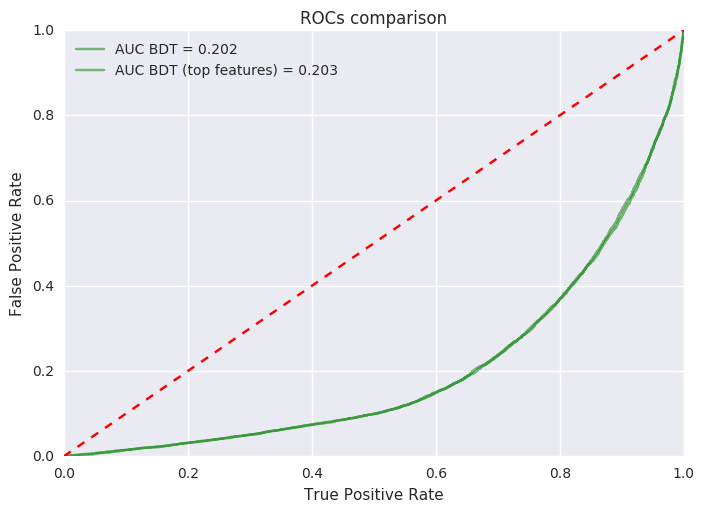

In [19]:
plt.title('ROCs comparison')
plt.plot(tpr_bdt,fpr_bdt, 'g', alpha=0.5, label = 'AUC BDT = %0.3f' % AUC_bdt)
plt.plot(tpr_bdt_high_import,fpr_bdt_high_import, 'g', alpha=0.5, label = 'AUC BDT (top features) = %0.3f' % AUC_bdt_high_import)
plt.legend(loc = 'upper left')
plt.plot([0, 1], [0, 1],'r--')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')

plt.show()

### roughly exact same performance without those features

## Feature importance for the NN: Permutation importance
There is no built in way to rank features for the NN in keras. Obviously a Gini importance only works for tree-based classifiers. As an alternative we could inspect the permutation importance. This means that we can shuffle the patient data of a given feature, and inspect how the performance of the NN is altered. If a feature is hardly used, shuffling the data of that feature will have a minor effect, whereas is a feature is often used, it will largely affect the performance.


In [110]:
print "--> Original AUC was: %.3f"%AUC_NN

NN_impotance_array = []

for feat in feature_names:
    input_data_tmp_ = copy.deepcopy(input_data)
    input_data_tmp_.loc[:,feat] = input_data_tmp_.loc[:,feat].sample(frac=1).reset_index(drop=True)
    testing_size_tmp_=0.3
    input_data_train_tmp_, input_data_test_tmp_ , target_data_train_tmp_, target_data_test_tmp_, target_data_categorical_train_tmp_, target_data_categorical_test_tmp_ = train_test_split(input_data_tmp_, target_data, target_data_categorical, test_size=testing_size_tmp_)
    output_test_tmp_ = DataFrame(data=model.predict(input_data_test_tmp_.values)[:,1],columns=["discriminator_NN_tmp_"])
    output_target_tmp_ = DataFrame(data=np.asarray(target_data_test_tmp_),columns=["disease"])
    fpr_NN_tmp_, tpr_NN_tmp_, thres_NN_tmp_ = roc_curve( output_target_tmp_,output_test_tmp_ )
    AUC_NN_tmp_ = 1-roc_auc_score( output_target_tmp_,output_test_tmp_  )
    print "When shuffling '%s', tha AUC becomes: %.3f"%(feat,AUC_NN_tmp_ )
    NN_impotance_array.append((feat,AUC_NN_tmp_))

NN_impotance_array.sort(key = lambda x: x[1],reverse=True) 
for idx,(name,imp) in enumerate(NN_impotance_array):
    print idx, name, imp



--> Original AUC was: 0.207
When shuffling 'age', tha AUC becomes: 0.243
When shuffling 'gender', tha AUC becomes: 0.214
When shuffling 'height', tha AUC becomes: 0.253
When shuffling 'weight', tha AUC becomes: 0.342
When shuffling 'ap_hi', tha AUC becomes: 0.403
When shuffling 'ap_lo', tha AUC becomes: 0.214
When shuffling 'cholesterol', tha AUC becomes: 0.211
When shuffling 'gluc', tha AUC becomes: 0.209
When shuffling 'smoke', tha AUC becomes: 0.210
When shuffling 'alco', tha AUC becomes: 0.211
When shuffling 'active', tha AUC becomes: 0.210
When shuffling 'bmi', tha AUC becomes: 0.260
When shuffling 'high_bp', tha AUC becomes: 0.206
0 ap_hi 0.40324825553
1 weight 0.34204817198
2 bmi 0.259752309496
3 height 0.252694388565
4 age 0.243264685548
5 gender 0.214107229607
6 ap_lo 0.213977954512
7 alco 0.211356504863
8 cholesterol 0.210787283638
9 smoke 0.21005426887
10 active 0.209515006311
11 gluc 0.209114775423
12 high_bp 0.206482620806


### The highest ROC score indicates the worst performance. This means that variable was very important to the NN.

In [99]:
features_NN_important = [feat for idx,(feat,imp) in enumerate(NN_impotance_array) if idx<len(NN_impotance_array)-4]
features_NN_important

testing_size=0.3
input_data_NN_high_import = input_data[features_NN_important]
input_data_NN_high_import_train, input_data_NN_high_import_test , target_data_NN_high_import_train, target_data_NN_high_import_test, target_data_NN_high_import_categorical_train, target_data_NN_high_import_categorical_test = train_test_split(input_data_NN_high_import, target_data, target_data_categorical, test_size=testing_size)


In [101]:
init_learning_rate_sgd = 0.001
nb_epoch = 100
batch_size = 128
input_dim = input_data_NN_high_import.shape[1:]
dropout=0.2
nb_classes=2

decay_sgd = init_learning_rate_sgd/(float(nb_epoch) )
sgd = SGD(lr=init_learning_rate_sgd, decay=decay_sgd, momentum=0.7, nesterov=True)


model_important = Sequential([
    Dense(50, activation='relu',input_shape = input_dim),
    Dropout(dropout),
    Dense(20, activation='relu'),
    Dropout(dropout),
    Dense(2, activation='softmax')
  ])

model_important.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

#model = load_model("model_checkpoint_NN_important_save.hdf5")


print model.summary()

train_history_important = model_important.fit(input_data_NN_high_import_train.values, target_data_NN_high_import_categorical_train, batch_size=batch_size, nb_epoch=nb_epoch, validation_data=(input_data_NN_high_import_test.values, target_data_NN_high_import_categorical_test), callbacks = [ModelCheckpoint(os.getcwd() + "/model_checkpoint_NN_important_save.hdf5")], shuffle=True,verbose=1)
pickle.dump(train_history_important.history,open(os.getcwd() + "/loss_and_acc_NN_important.pkl",'wb'))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_13 (Dense)                 (None, 50)            700         dense_input_1[0][0]              
____________________________________________________________________________________________________
dropout_9 (Dropout)              (None, 50)            0           dense_13[0][0]                   
____________________________________________________________________________________________________
dense_14 (Dense)                 (None, 20)            1020        dropout_9[0][0]                  
____________________________________________________________________________________________________
dropout_10 (Dropout)             (None, 20)            0           dense_14[0][0]                   
___________________________________________________________________________________________

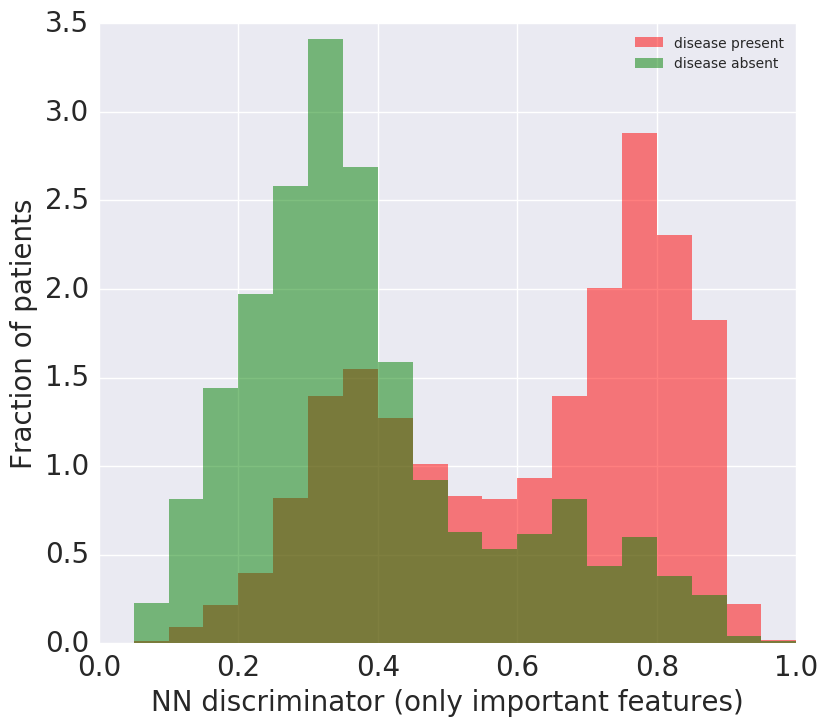

In [102]:
output_test_important = DataFrame(data=model_important.predict(input_data_NN_high_import_test.values)[:,1],columns=["discriminator_NN_high_import_NN"])
output_target_important = DataFrame(data=np.asarray(target_data_NN_high_import_test),columns=["disease"])
bins=np.arange(0.,1.05,0.05)
fig_ = draw_feat_histogram("discriminator_NN_high_import_NN",output_test_important["discriminator_NN_high_import_NN"],output_target_important["disease"],bins,x_axis_label="NN discriminator (only important features)",set_log=False)
plt.draw()

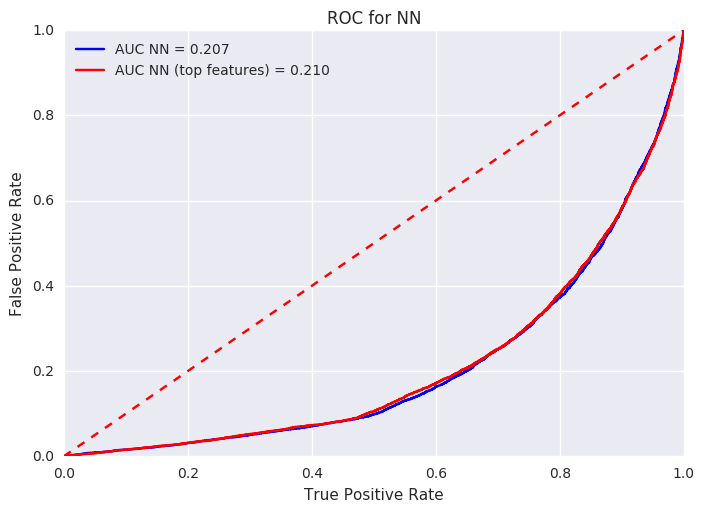

In [108]:
fpr_NN_important, tpr_NN_important, thres_NN_important = roc_curve( output_target_important,output_test_important )
AUC_NN_important = 1-roc_auc_score( output_target_important,output_test_important  )

plt.title('ROC for NN')
plt.plot(tpr_NN,fpr_NN, 'b', label = 'AUC NN = %0.3f' % AUC_NN)
plt.plot(tpr_NN_important,fpr_NN_important, 'r', label = 'AUC NN (top features) = %0.3f' % AUC_NN_important)
plt.legend(loc = 'upper left')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')

plt.show()

### Nearly same performance without those features

In [111]:
print "--> Feature importance for NN"
NN_impotance_array.sort(key = lambda x: x[1],reverse=True) 
for idx,(name,imp) in enumerate(NN_impotance_array):
    print idx, name, imp
    
print ""
print "--> Feature importance for BDT"
for idx,(name,imp) in enumerate(bdt_importance):
    print idx, name, imp

--> Feature importance for NN
0 ap_hi 0.40324825553
1 weight 0.34204817198
2 bmi 0.259752309496
3 height 0.252694388565
4 age 0.243264685548
5 gender 0.214107229607
6 ap_lo 0.213977954512
7 alco 0.211356504863
8 cholesterol 0.210787283638
9 smoke 0.21005426887
10 active 0.209515006311
11 gluc 0.209114775423
12 high_bp 0.206482620806

--> Feature importance for BDT
0 age 0.31843120131
1 bmi 0.217981207162
2 ap_hi 0.135079214116
3 height 0.0873831771859
4 weight 0.0840948781198
5 ap_lo 0.0749610482172
6 gluc 0.0223815178504
7 cholesterol 0.0194148455604
8 active 0.01177424731
9 gender 0.00978404319694
10 smoke 0.00895152931206
11 alco 0.00743000582166
12 high_bp 0.00233308483789


### Some differences in importance for the two models. Could be due to different metric for importance. But can also indicate that each model uses the correlations slightly differently.

### It is however clear that age, BMI, weight, height and Systolic BP are the most important features to detect the disease. i.e. Older, overweight patients with a high BP are more susceptible.

### It also seems like high BP is a constructed variable that the ML models can easily learn themselves. It clearly has some discriminating power from the EDA, but it is always ranked lowest. 